**Data Loading**

In [ ]:
import pandas as pd
import numpy as np

#Setting a global seed
np.random.seed(42)I

In [46]:
data = pd.read_csv('paddyclean.csv')
data.head()

,Hectares,Agriblock,Variety,Soil Types,Seedrate(in Kg),LP_Mainfield(in Tonnes),Nursery,Nursery area (Cents),LP_nurseryarea(in Tonnes),DAP_20days,...,Wind Direction_D1_D30,Wind Direction_D31_D60,Wind Direction_D61_D90,Wind Direction_D91_D120,Relative Humidity_D1_D30,Relative Humidity_D31_D60,Relative Humidity_D61_D90,Relative Humidity_D91_D120,Trash(in bundles),Paddy yield(in Kg)
0,6,Cuddalore,CO_43,alluvial,150,75.0,dry,120,6,240,...,SW,W,NNW,WSW,72.0,78,88,85,540,35028
1,6,Kurinjipadi,ponmani,clay,150,75.0,wet,120,6,240,...,NW,S,SE,SSE,64.6,85,84,87,600,35412
2,6,Panruti,delux ponni,alluvial,150,75.0,dry,120,6,240,...,ENE,NE,NNE,W,85.0,96,84,79,600,36300
3,6,Kallakurichi,CO_43,clay,150,75.0,wet,120,6,240,...,W,WNW,SE,S,88.5,95,81,84,540,35016
4,6,Sankarapuram,ponmani,alluvial,150,75.0,dry,120,6,240,...,SSE,W,SW,NW,72.7,91,83,81,600,34044


In [47]:
X = data.drop("Paddy yield(in Kg)", axis=1)
y = data["Paddy yield(in Kg)"]


This segment of the code involves importing the data and splitting it into X and y variables based on our response variable. our X is every column excluding the response (paddy yield) and our y is only our response (paddy yield). Additionally a global seed is set.

**Ridge Regression**

In [48]:
alpha_values = [0.1, 1.0,10.0, 100.0]

I chose to use ridge regression due to a lack of confidence in whether some variables are relevant or not. 

In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Identify columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Preprocessor
preprocess = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Pipeline
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('ridge', Ridge())
])

# Grid search params MUST refer to this pipeline
param_grid = {
    'ridge__alpha': alpha_values
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X, y)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
print("Best alpha:", grid_search.best_params_['ridge__alpha'])
print("Best cross-validation score:", grid_search.best_score_)

Best alpha: 10.0
Best cross-validation score: 0.7778865628864732


Due to prior issues with variable types i separated columns by numeric and categorical and then preprocessed them by using a standard scaler on the numeric columns and one hot encoding the categorical columns. Within the pipeline I have preprocessing and ridge regression as requested. Following that I perform gridsearch to find the best parameters and fit that with the original data. I then have the model return the best alpha and cross validation score. 

Next I'm going to select for most important features based on the coefficients.

In [50]:

preprocess = best_model.named_steps["preprocess"]
ridge = best_model.named_steps["ridge"]


feature_names = preprocess.get_feature_names_out()


coefs = ridge.coef_

#listing most impactful features
importance_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs,
    "abs_coefficient": np.abs(coefs)
}).sort_values(by="abs_coefficient", ascending=False)

print(importance_df)


                            feature  coefficient  abs_coefficient
8               num__Potassh_50Days   901.362623       901.362623
2      num__LP_Mainfield(in Tonnes)   901.362623       901.362623
1              num__Seedrate(in Kg)   901.362623       901.362623
9        num__Micronutrients_70Days   901.362623       901.362623
5                   num__DAP_20days   901.362623       901.362623
..                              ...          ...              ...
61  cat__Wind Direction_D61_D90_NNE     0.165604         0.165604
50   cat__Wind Direction_D1_D30_ENE     0.165604         0.165604
33   num__Relative Humidity_D61_D90     0.052334         0.052334
15           num__51_70DRain(in mm)     0.047184         0.047184
16              num__51_70AI(in mm)    -0.047184         0.047184

[71 rows x 3 columns]


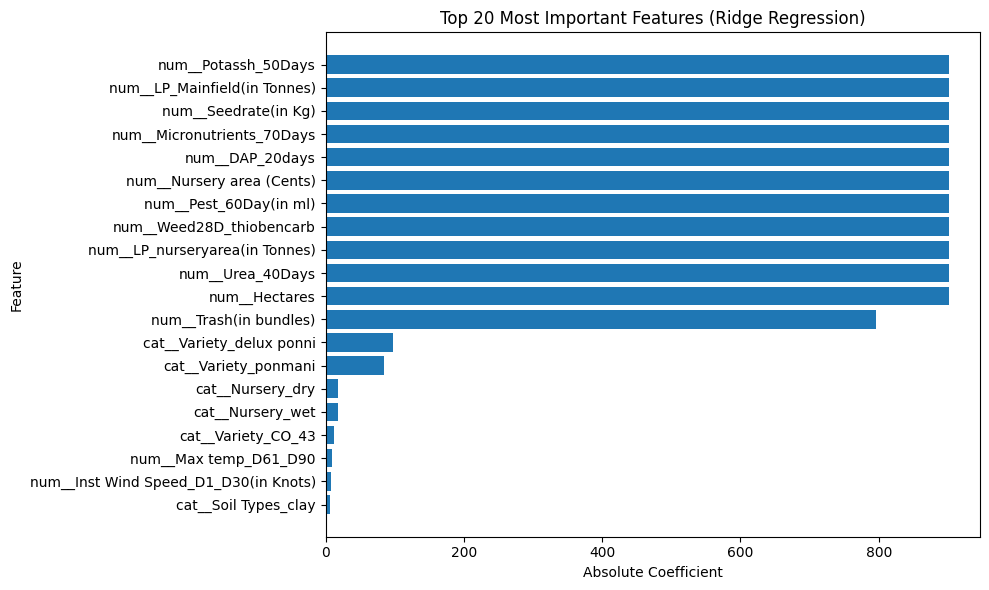

In [51]:
import matplotlib.pyplot as plt

N = 20
top_features = importance_df.sort_values("abs_coefficient", ascending=False).head(N)

plt.figure(figsize=(10, 6))
plt.barh(top_features["feature"], top_features["abs_coefficient"])
plt.xlabel("Absolute Coefficient")
plt.ylabel("Feature")
plt.title(f"Top {N} Most Important Features (Ridge Regression)")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

Here I plot the top features based on coefficient values.

**Support Vector Machine (support vector regression)**

Best params: {'svr__C': 100, 'svr__degree': 2, 'svr__epsilon': 1, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}
Best score: 0.7679239516237079


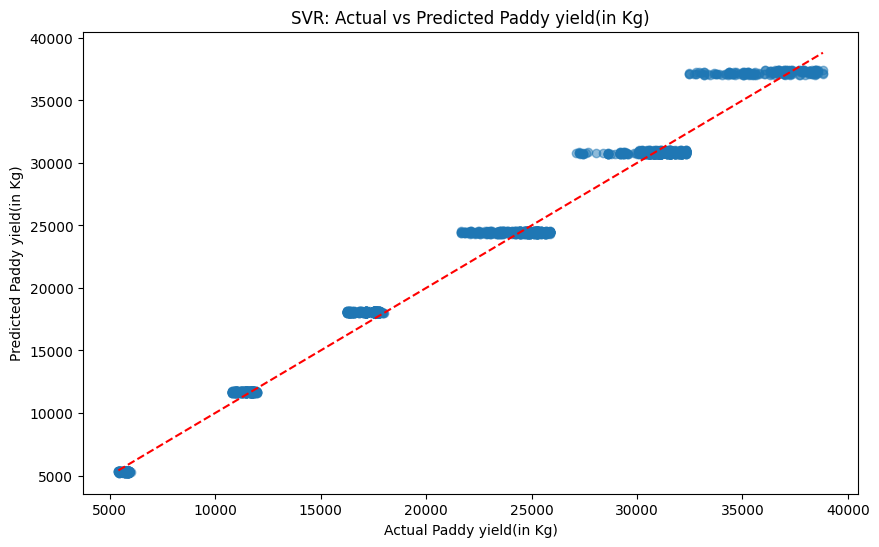

In [52]:
# SVR pipeline
from sklearn.svm import SVR
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('svr', SVR())
])

# Hyperparameter grid for SVR
param_grid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 1],
    'svr__kernel': ['rbf', 'poly', 'linear'],
    # ONLY used when kernel='poly'
    'svr__degree': [2, 3, 4],
    # ONLY used for 'rbf' or 'poly'
    'svr__gamma': ['scale', 'auto']
}

# Grid Search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X, y)

print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

plt.figure(figsize=(10,6))
plt.scatter(y, grid_search.predict(X), alpha=0.5)
plt.xlabel('Actual Paddy yield(in Kg)')
plt.ylabel('Predicted Paddy yield(in Kg)')
plt.title('SVR: Actual vs Predicted Paddy yield(in Kg)')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.show()

Similarly to the prior method here I fit a pipeline using preprocessing and support vector regression. Grid search was performed and fit within the pipeline. Additionally the best parameters were selected and plotted along with the regression line.

In [53]:
from sklearn.inspection import permutation_importance

best_model = grid_search.best_estimator_

result = permutation_importance(
    best_model, X, y,
    n_repeats=20,
    random_state=42,
    n_jobs=-1
)



In [54]:
best_model = grid_search.best_estimator_

preprocess = best_model.named_steps["preprocess"]
svr = best_model.named_steps["svr"]

X_transformed = preprocess.transform(X)

print("Transformed shape:", X_transformed.shape)


Transformed shape: (2789, 71)


In [55]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    svr,
    X_transformed,
    y,
    n_repeats=20,
    random_state=42,
    n_jobs=-1
)


In [56]:
import pandas as pd

perm_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": result.importances_mean
}).sort_values("importance", ascending=False)

print(perm_imp_df)


                         feature  importance
1           num__Seedrate(in Kg)    0.017026
5                num__DAP_20days    0.017026
2   num__LP_Mainfield(in Tonnes)    0.017026
9     num__Micronutrients_70Days    0.017026
3      num__Nursery area (Cents)    0.017026
..                           ...         ...
23         num__Min temp_D61_D90   -0.000001
19          num__Min temp_D1_D30   -0.000002
24         num__Max temp_D61_D90   -0.000002
43      cat__Variety_delux ponni   -0.000010
44          cat__Variety_ponmani   -0.000012

[71 rows x 2 columns]


Here I use permutation imoprtance to rank the coefficients.

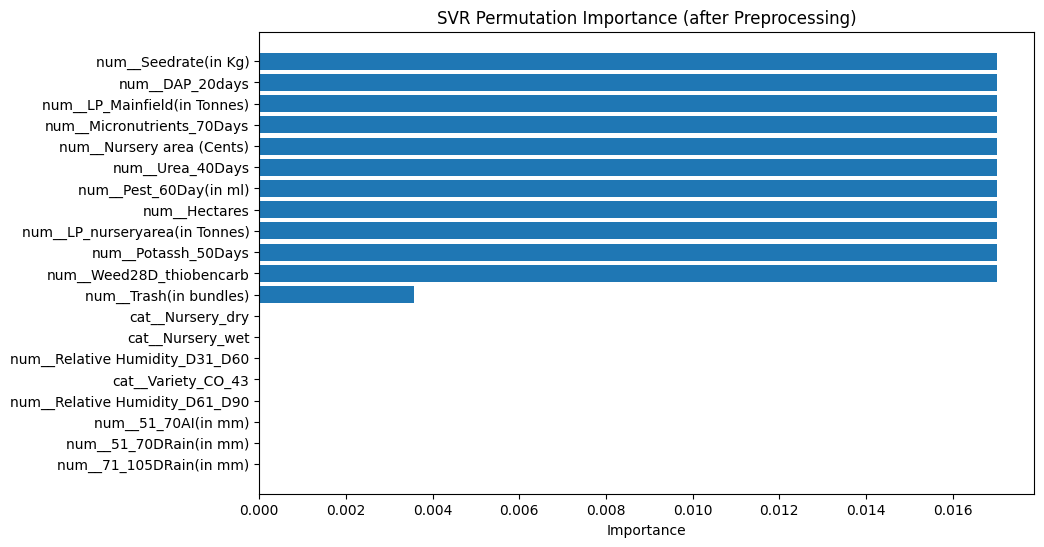

In [57]:
import matplotlib.pyplot as plt

N = 20
top = perm_imp_df.head(N)

plt.figure(figsize=(10,6))
plt.barh(top["feature"], top["importance"])
plt.gca().invert_yaxis()
plt.title("SVR Permutation Importance (after Preprocessing)")
plt.xlabel("Importance")
plt.show()


The top features were then visualized using the permutation importance scores.